# Multi-channel Convolutional Sparse Coding

This notebook demonstrates the use of SPORCO to solve a convolutional sparse coding problem with a colour dictionary and a colour signal

$$\mathrm{argmin}_\mathbf{x} \; (1/2) \sum_c \left\| \sum_m \mathbf{d}_{c,m} * \mathbf{x}_m -\mathbf{s}_c \right\|_2^2 + \lambda \sum_m \| \mathbf{x}_m \|_1$$

where $\mathbf{d}_{c,m}$ is channel $c$ of the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_m$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter, and $\mathbf{s}_c$ is channel $c$ of the input image.



Import modules and configure matplotlib output to notebook.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco import util
from sporco import plot
import sporco.metric as sm
from sporco.admm import cbpdn

%matplotlib inline

Load test image and compute lowpass and highpass components.

In [2]:
# Load test image
img = util.ExampleImages().image('kodim23', scaled=True)[160:416,60:316]

# Highpass filter test image
npd = 16
fltlmbd = 10
sl, sh = util.tikhonov_filter(img, fltlmbd, npd)

Load colour dictionary and display it.

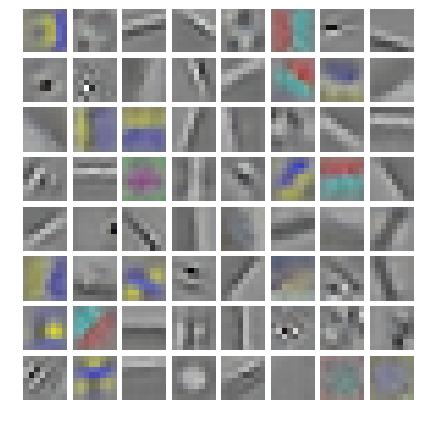

In [3]:
# Load dictionary
D = util.convdicts()['RGB:8x8x3x64']

# Display dictionary
fig = plot.figure(figsize=(7,7))
fgax = plot.imview(util.tiledict(D), fgrf=fig)

Set CBPDN solver class options.

In [4]:
# Set up ConvBPDN options
lmbda = 1e-1
opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 200,
                              'LinSolveCheck' : True, 'RelStopTol' : 5e-3,
                              'AuxVarObj' : False})

Initialise and run CBPDN solver and then reconstruct image from sparse representation.

In [5]:
# Solve CBPDN problem
b = cbpdn.ConvBPDN(D, sh, lmbda, opt)
X = b.solve()

print("ConvBPDN solve time: %.2fs" % b.runtime)

# Reconstruct representation
shr = b.reconstruct().squeeze()
imgr = sl + shr
print("Reconstruction PSNR: %.2fdB\n" % sm.psnr(img, imgr))

Itn   Fnc       DFid      Regℓ1     r         s         ρ         
----------------------------------------------------------------
   0  2.18e+02  2.09e+00  2.16e+03  9.76e-01  7.28e-02  6.00e+00
   1  1.90e+02  8.55e+00  1.81e+03  8.24e-01  2.48e-01  6.00e+00
   2  1.63e+02  1.27e+01  1.50e+03  3.62e-01  2.87e-01  7.73e+00
   3  1.76e+02  1.39e+01  1.62e+03  2.86e-01  1.86e-01  6.13e+00
   4  1.61e+02  1.40e+01  1.47e+03  2.51e-01  1.40e-01  5.38e+00
   5  1.43e+02  1.48e+01  1.28e+03  2.17e-01  1.12e-01  5.38e+00
   6  1.34e+02  1.58e+01  1.18e+03  1.86e-01  8.34e-02  5.38e+00
   7  1.28e+02  1.67e+01  1.11e+03  1.50e-01  7.15e-02  5.38e+00
   8  1.24e+02  1.72e+01  1.07e+03  1.22e-01  6.59e-02  5.38e+00
   9  1.22e+02  1.74e+01  1.05e+03  1.04e-01  5.75e-02  5.38e+00
  10  1.19e+02  1.75e+01  1.01e+03  9.12e-02  5.05e-02  5.38e+00
  11  1.14e+02  1.76e+01  9.66e+02  8.12e-02  4.61e-02  5.38e+00
  12  1.10e+02  1.79e+01  9.23e+02  7.29e-02  4.16e-02  5.38e+00
  13  1.07e+02  1.81e+0

Display low pass component and sum of absolute values of coefficient maps of highpass component.

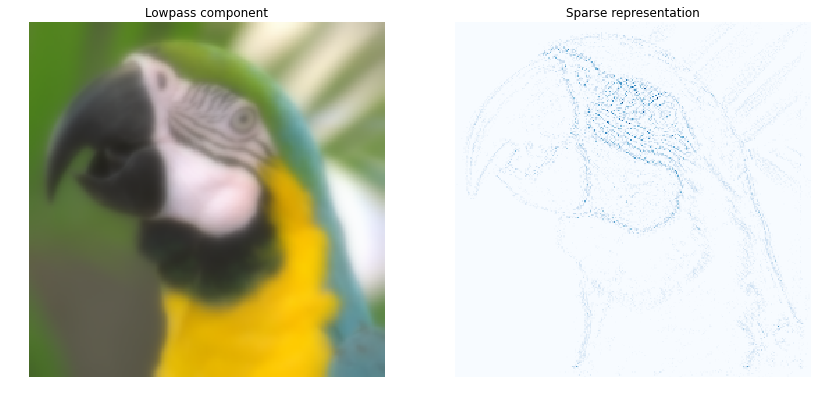

In [6]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(sl, title='Lowpass component', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(np.sum(abs(X), axis=b.cri.axisM).squeeze(), cmap=plot.cm.Blues,
            title='Sparse representation', fgrf=fig)

Display original and reconstructed images.

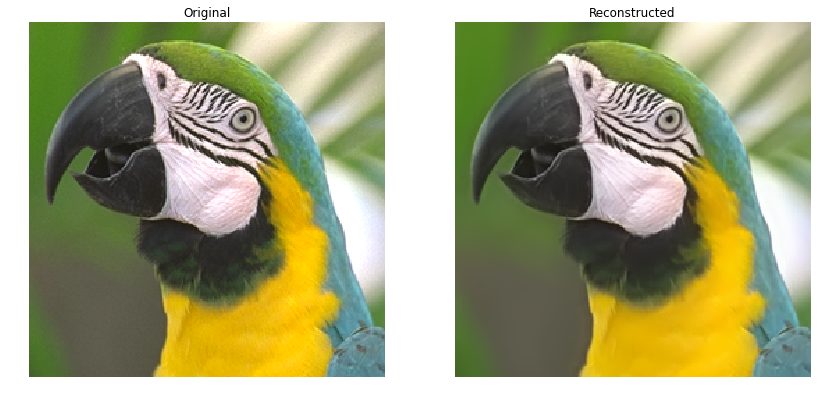

In [7]:
fig = plot.figure(figsize=(14,7))
plot.subplot(1,2,1)
fgax = plot.imview(img, title='Original', fgrf=fig)
plot.subplot(1,2,2)
fgax = plot.imview(imgr, title='Reconstructed', fgrf=fig)

Plot functional evolution during ADMM iterations.

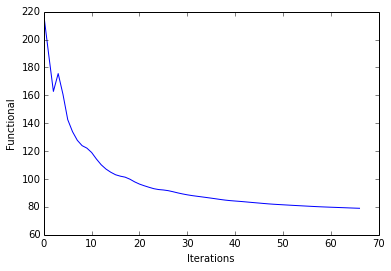

In [8]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')
plot.close()

Plot evolution of ADMM residuals and ADMM penalty parameter.

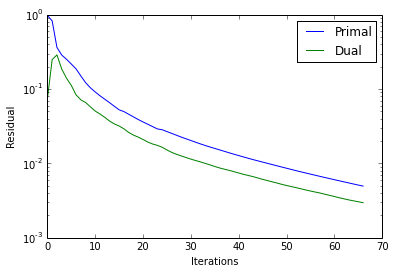

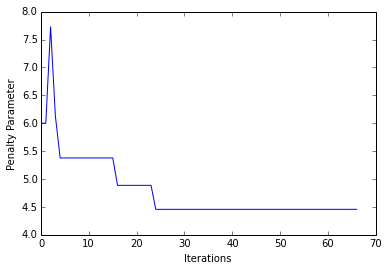

In [9]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual']);
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')
plot.close()